In [1]:
%pip install pandas
%pip install torch
%pip install scikit-learn
%pip install numpy
%pip install dask
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\mannat2\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\mannat2\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\mannat2\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\mannat2\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\mannat2\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\mannat2\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Goal: Build a classification model to segment the customers based on the account data.

classify the Accounts eligible for Credit Line Increase without Risk, Accounts eligible for Credit Line
Increase but has risk of potential defaults or fraud, No Credit Line Increase required and Non-Performing
accounts that pose a high risk.

# Data Cleaning and Preprocessing

In [36]:
import pandas as pd
import numpy as np

In [5]:
account_dim = pd.read_csv("/Users/preritharunkumar/datathon/consumer_spending_ml/tmp/datathon/data/account_dim_20250325.csv")
fraud_claim_case = pd.read_csv("/Users/preritharunkumar/datathon/consumer_spending_ml/tmp/datathon/data/fraud_claim_case_20250325.csv")
fraud_claim_tran = pd.read_csv("/Users/preritharunkumar/datathon/consumer_spending_ml/tmp/datathon/data/fraud_claim_tran_20250325.csv")
rams_batch_cur = pd.read_csv("/Users/preritharunkumar/datathon/consumer_spending_ml/tmp/datathon/data/rams_batch_cur_20250325.csv")
statement_fact = pd.read_csv("/Users/preritharunkumar/datathon/consumer_spending_ml/tmp/datathon/data/statement_fact_20250325.csv")
syf_id = pd.read_csv("/Users/preritharunkumar/datathon/consumer_spending_ml/tmp/datathon/data/syf_id_20250325.csv")
transaction_fact = pd.read_csv("/Users/preritharunkumar/datathon/consumer_spending_ml/tmp/datathon/data/transaction_fact_20250325.csv")
wrld_stor_tran_fact = pd.read_csv("/Users/preritharunkumar/datathon/consumer_spending_ml/tmp/datathon/data/wrld_stor_tran_fact_20250325.csv")

In [6]:
rams_batch_cur = rams_batch_cur[['cu_account_nbr', 'cu_bhv_scr', 'cu_crd_bureau_scr', 'ca_avg_utilz_lst_6_mnths', 'mo_tot_sales_array_1', 'mo_tot_sales_array_2', 'mo_tot_sales_array_3', 'mo_tot_sales_array_4', 'mo_tot_sales_array_5', 'mo_tot_sales_array_6', 'cu_cash_line_am', 'cu_crd_line', 'cu_otb', 'cu_nbr_days_dlq', 'ca_max_dlq_lst_6_mnths', 'ca_nsf_count_lst_12_months', 'cu_cur_nbr_due']]
rams_batch_cur.drop(columns=['mo_tot_sales_array_1', 'mo_tot_sales_array_2', 'mo_tot_sales_array_3', 'mo_tot_sales_array_4', 'mo_tot_sales_array_5', 'mo_tot_sales_array_6'], inplace=True)
account_dim = account_dim[['current_account_nbr', 'payment_hist_1_12_mths', 'payment_hist_13_24_mths', 'overlimit_type_flag', 'external_status_reason_code']]
statement_fact = statement_fact[['current_account_nbr', 'return_check_cnt_total']]
fraud_claim_case = fraud_claim_case[['current_account_nbr', 'gross_fraud_amt', 'net_fraud_amt']]
syf_id = syf_id[['account_nbr_pty', 'confidence_level']]

In [7]:
rams_batch_cur = rams_batch_cur.rename(columns={"cu_account_nbr": "current_account_nbr"})
fraud_claim_case = fraud_claim_case.rename(columns={"current_account_nbr_pty": "current_account_nbr"})
syf_id = syf_id.rename(columns={"account_nbr_pty": "current_account_nbr"})

In [8]:
master_df = account_dim.merge(rams_batch_cur, on='current_account_nbr', how='outer')
master_df = master_df.merge(statement_fact, on="current_account_nbr", how='outer')
master_df = master_df.merge(fraud_claim_case, on="current_account_nbr", how='outer')
master_df = master_df.merge(syf_id, on="current_account_nbr", how='outer')

In [9]:
master_df.drop(columns=['overlimit_type_flag', 'payment_hist_1_12_mths', 'payment_hist_13_24_mths', 'cu_cash_line_am', 'cu_otb', 'ca_nsf_count_lst_12_months', 'external_status_reason_code'], inplace=True)

In [10]:
master_df

,current_account_nbr,cu_bhv_scr,cu_crd_bureau_scr,ca_avg_utilz_lst_6_mnths,cu_crd_line,cu_nbr_days_dlq,ca_max_dlq_lst_6_mnths,cu_cur_nbr_due,return_check_cnt_total,gross_fraud_amt,net_fraud_amt,confidence_level
0,00gwujJkd597VxLd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIGH
1,00iP5U82D8XwVQ9G,735.0,793.0,14.0,3500.0,0.0,0.0,0.0,0.0,NaN,NaN,HIGH
2,00iP5U82D8XwVQ9G,735.0,793.0,14.0,3500.0,0.0,0.0,0.0,0.0,NaN,NaN,HIGH
3,00iP5U82D8XwVQ9G,735.0,793.0,14.0,3500.0,0.0,0.0,0.0,0.0,NaN,NaN,HIGH
4,00iP5U82D8XwVQ9G,735.0,793.0,14.0,3500.0,0.0,0.0,0.0,0.0,NaN,NaN,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...
3983106,zzztTVczEiGgAEJi,13.0,832.0,0.0,9900.0,0.0,0.0,0.0,0.0,NaN,NaN,HIGH
3983107,zzztTVczEiGgAEJi,13.0,832.0,0.0,9900.0,0.0,0.0,0.0,0.0,NaN,NaN,HIGH
3983108,zzztTVczEiGgAEJi,13.0,832.0,0.0,9900.0,0.0,0.0,0.0,0.0,NaN,NaN,HIGH
3983109,zzztTVczEiGgAEJi,13.0,832.0,0.0,9900.0,0.0,0.0,0.0,0.0,NaN,NaN,HIGH


In [11]:
def conf_level(row):
    if row['confidence_level'] == 'HIGH':
        return 1
    else:
        return 0

In [12]:
master_df['confidence_level'] = master_df.apply(conf_level, axis=1)

In [13]:
master_df

,current_account_nbr,cu_bhv_scr,cu_crd_bureau_scr,ca_avg_utilz_lst_6_mnths,cu_crd_line,cu_nbr_days_dlq,ca_max_dlq_lst_6_mnths,cu_cur_nbr_due,return_check_cnt_total,gross_fraud_amt,net_fraud_amt,confidence_level
0,00gwujJkd597VxLd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,00iP5U82D8XwVQ9G,735.0,793.0,14.0,3500.0,0.0,0.0,0.0,0.0,NaN,NaN,1
2,00iP5U82D8XwVQ9G,735.0,793.0,14.0,3500.0,0.0,0.0,0.0,0.0,NaN,NaN,1
3,00iP5U82D8XwVQ9G,735.0,793.0,14.0,3500.0,0.0,0.0,0.0,0.0,NaN,NaN,1
4,00iP5U82D8XwVQ9G,735.0,793.0,14.0,3500.0,0.0,0.0,0.0,0.0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3983106,zzztTVczEiGgAEJi,13.0,832.0,0.0,9900.0,0.0,0.0,0.0,0.0,NaN,NaN,1
3983107,zzztTVczEiGgAEJi,13.0,832.0,0.0,9900.0,0.0,0.0,0.0,0.0,NaN,NaN,1
3983108,zzztTVczEiGgAEJi,13.0,832.0,0.0,9900.0,0.0,0.0,0.0,0.0,NaN,NaN,1
3983109,zzztTVczEiGgAEJi,13.0,832.0,0.0,9900.0,0.0,0.0,0.0,0.0,NaN,NaN,1


In [14]:
fill_values = {
    'cu_bhv_scr' : master_df['cu_bhv_scr'].mean(),
    'cu_crd_bureau_scr' : master_df['cu_crd_bureau_scr'].mean(),
    'ca_avg_utilz_lst_6_mnths' : master_df['ca_avg_utilz_lst_6_mnths'].mean(),
    'cu_crd_line' : master_df['cu_crd_line'].mean(),
    'cu_nbr_days_dlq' : 0,
    'ca_max_dlq_lst_6_mnths' : 0,
    'return_check_cnt_total' : 0,
    'gross_fraud_amt' : 0,
    'net_fraud_amt' : 0,
    'cu_cur_nbr_due': 0
}

In [15]:
# check if this is the right way to do and deal with the NAN values
master_df.fillna(value=fill_values, inplace=True)

In [16]:
master_df

,current_account_nbr,cu_bhv_scr,cu_crd_bureau_scr,ca_avg_utilz_lst_6_mnths,cu_crd_line,cu_nbr_days_dlq,ca_max_dlq_lst_6_mnths,cu_cur_nbr_due,return_check_cnt_total,gross_fraud_amt,net_fraud_amt,confidence_level
0,00gwujJkd597VxLd,495.665349,749.315329,16.372011,6697.17423,0.0,0.0,0.0,0.0,0.0,0.0,1
1,00iP5U82D8XwVQ9G,735.000000,793.000000,14.000000,3500.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
2,00iP5U82D8XwVQ9G,735.000000,793.000000,14.000000,3500.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
3,00iP5U82D8XwVQ9G,735.000000,793.000000,14.000000,3500.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
4,00iP5U82D8XwVQ9G,735.000000,793.000000,14.000000,3500.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3983106,zzztTVczEiGgAEJi,13.000000,832.000000,0.000000,9900.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
3983107,zzztTVczEiGgAEJi,13.000000,832.000000,0.000000,9900.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
3983108,zzztTVczEiGgAEJi,13.000000,832.000000,0.000000,9900.00000,0.0,0.0,0.0,0.0,0.0,0.0,1
3983109,zzztTVczEiGgAEJi,13.000000,832.000000,0.000000,9900.00000,0.0,0.0,0.0,0.0,0.0,0.0,1


# K-Means Clustering

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [18]:
master_df.isna().value_counts()

current_account_nbr  cu_bhv_scr  cu_crd_bureau_scr  ca_avg_utilz_lst_6_mnths  cu_crd_line  cu_nbr_days_dlq  ca_max_dlq_lst_6_mnths  cu_cur_nbr_due  return_check_cnt_total  gross_fraud_amt  net_fraud_amt  confidence_level
False                False       False              False                     False        False            False                   False           False                   False            False          False               3983111
Name: count, dtype: int64

In [19]:
master_df = master_df.groupby('current_account_nbr').agg('mean').reset_index()

In [20]:
master_df

,current_account_nbr,cu_bhv_scr,cu_crd_bureau_scr,ca_avg_utilz_lst_6_mnths,cu_crd_line,cu_nbr_days_dlq,ca_max_dlq_lst_6_mnths,cu_cur_nbr_due,return_check_cnt_total,gross_fraud_amt,net_fraud_amt,confidence_level
0,00gwujJkd597VxLd,495.665349,749.315329,16.372011,6697.17423,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00iP5U82D8XwVQ9G,738.800000,790.000000,12.600000,3500.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,00oyr3QppAzjLws4,662.833333,664.000000,88.666667,2900.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,01SEhQXHbPJRc1Go,12.000000,729.833333,0.000000,1750.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,01wbqz3obYPYxLvR,5.750000,623.000000,0.000000,400.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18065,zzBy2qNM78aRV580,737.500000,795.833333,5.333333,14800.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18066,zzEuUBBmvGiVnabb,746.833333,758.000000,8.833333,6000.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18067,zzR9PvG7dY9u5iHU,3.000000,650.000000,6.000000,5000.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18068,zzXGgGu6ysGwGH1J,0.000000,653.000000,0.000000,1000.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
standardized_columns = [
    'cu_bhv_scr', 'cu_crd_bureau_scr', 'ca_avg_utilz_lst_6_mnths', 'return_check_cnt_total',
    'cu_crd_line', 'cu_nbr_days_dlq', 'ca_max_dlq_lst_6_mnths', 'cu_cur_nbr_due', 
    'gross_fraud_amt', 'net_fraud_amt', 'confidence_level'
]

In [22]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(master_df[standardized_columns])

KMeans(n_clusters=4, random_state=42)

In [23]:
score = silhouette_score(master_df[standardized_columns], kmeans.labels_, metric='euclidean')
score

np.float64(0.6240206891502782)

In [24]:
predictions = kmeans.predict(master_df[standardized_columns])

In [25]:
master_df['cluster'] = predictions

In [26]:
def cluster_summary(row):
    if (row['cluster'] == 3):
        return 'Accounts eligible for Credit Line Increase without Risk'
    elif (row['cluster'] == 0):
        return 'Non-performing accounts that pose a high risk'
    elif (row['cluster'] == 2):
        return 'Accounts eligible for Credit Line Increase but has risk of potential defaults or fraud'
    else:
        return 'No Credit Line Increase required'

In [27]:
master_df['customer_segmentation'] = master_df.apply(cluster_summary, axis=1)

In [28]:
master_df[master_df['cluster'] == 0].describe()

,cu_bhv_scr,cu_crd_bureau_scr,ca_avg_utilz_lst_6_mnths,cu_crd_line,cu_nbr_days_dlq,ca_max_dlq_lst_6_mnths,cu_cur_nbr_due,return_check_cnt_total,gross_fraud_amt,net_fraud_amt,confidence_level,cluster
count,8614.000000,8614.000000,8614.000000,8614.000000,8614.000000,8614.000000,8614.000000,8614.000000,8614.000000,8614.000000,8614.000000,8614.0
mean,364.381136,696.694515,10.208375,1921.494786,1.111289,0.110599,0.037043,0.028272,1.282610,0.446897,0.994312,0.0
std,313.999322,135.297276,108.161841,1167.706439,4.062256,0.305795,0.135409,0.177658,36.427118,20.180287,0.075211,0.0
min,0.000000,0.000000,-999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,12.666667,648.000000,0.000000,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
50%,392.585714,712.500000,2.500000,1800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
75%,679.000000,787.791667,32.825000,2874.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
max,774.285714,850.000000,137.000000,4410.000000,60.000000,2.833333,2.000000,5.484848,2000.000000,1694.730000,1.000000,0.0


In [29]:
master_df[master_df['cluster'] == 1].describe()

,cu_bhv_scr,cu_crd_bureau_scr,ca_avg_utilz_lst_6_mnths,cu_crd_line,cu_nbr_days_dlq,ca_max_dlq_lst_6_mnths,cu_cur_nbr_due,return_check_cnt_total,gross_fraud_amt,net_fraud_amt,confidence_level,cluster
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.0
mean,707.097843,806.148650,14.098052,23792.073138,0.150283,0.025849,0.005009,0.119806,0.831015,0.781572,0.997525,1.0
std,156.202787,64.071985,15.659174,3335.536063,1.298327,0.147699,0.043278,0.399645,22.259116,22.216444,0.049721,0.0
min,0.000000,0.000000,-3.333333,19100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,735.625000,799.458333,4.150000,20000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
50%,750.619048,813.416667,10.250000,25000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
75%,759.666667,832.041667,17.541667,25000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
max,779.000000,850.000000,97.666667,50000.000000,20.000000,1.500000,0.666667,3.000000,631.510000,631.510000,1.000000,1.0


In [30]:
master_df[master_df['cluster'] == 2].describe()

,cu_bhv_scr,cu_crd_bureau_scr,ca_avg_utilz_lst_6_mnths,cu_crd_line,cu_nbr_days_dlq,ca_max_dlq_lst_6_mnths,cu_cur_nbr_due,return_check_cnt_total,gross_fraud_amt,net_fraud_amt,confidence_level,cluster
count,5821.000000,5821.000000,5821.000000,5821.000000,5821.000000,5821.000000,5821.000000,5821.000000,5821.000000,5821.000000,5821.000000,5821.0
mean,448.715281,750.359832,17.190035,6941.635150,0.653790,0.068808,0.021793,0.034405,2.784875,2.317473,0.995018,2.0
std,299.642569,102.715495,24.731613,1723.477702,2.977921,0.234485,0.099264,0.194773,77.507785,74.889783,0.070413,0.0
min,0.000000,0.000000,-20.833333,4430.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,14.000000,723.285714,0.000000,5500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.0
50%,578.666667,767.500000,5.750000,6697.174230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.0
75%,709.166667,805.000000,22.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.0
max,777.833333,850.000000,115.166667,10600.000000,60.000000,2.000000,2.000000,4.000000,4003.500000,4003.500000,1.000000,2.0


In [31]:
master_df[master_df['cluster'] == 3].describe()

,cu_bhv_scr,cu_crd_bureau_scr,ca_avg_utilz_lst_6_mnths,cu_crd_line,cu_nbr_days_dlq,ca_max_dlq_lst_6_mnths,cu_cur_nbr_due,return_check_cnt_total,gross_fraud_amt,net_fraud_amt,confidence_level,cluster
count,2827.000000,2827.000000,2827.000000,2827.000000,2827.000000,2827.000000,2827.000000,2827.000000,2827.000000,2827.000000,2827.000000,2827.0
mean,659.505137,791.690732,16.741850,14314.883050,0.290464,0.039690,0.009682,0.082392,2.359664,0.415306,0.998585,3.0
std,214.978502,80.458560,20.028448,1637.094058,1.605346,0.175424,0.053512,0.302807,65.943826,15.183408,0.037596,0.0
min,0.000000,0.000000,-16.800000,10683.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,708.816667,787.366667,3.414286,13000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.0
50%,743.666667,807.000000,10.666667,15000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.0
75%,755.333333,824.000000,21.226190,15000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.0
max,779.571429,850.000000,110.000000,19000.000000,25.000000,2.000000,0.833333,3.000000,3289.770000,712.640000,1.000000,3.0


In [32]:
master_df['customer_segmentation'].value_counts()

customer_segmentation
Non-performing accounts that pose a high risk                                             8614
Accounts eligible for Credit Line Increase but has risk of potential defaults or fraud    5821
Accounts eligible for Credit Line Increase without Risk                                   2827
No Credit Line Increase required                                                           808
Name: count, dtype: int64

# Results

Cluster 0: Non-performing accounts that pose a high risk

Cluster 1: No Credit Line Increase required

Cluster 2: Accounts eligible for Credit Line Increase but has risk of potential defaults or fraud 

Cluster 3: Accounts eligible for Credit Line Increase without Risk

Current silhouette score: 0.6240206891502786

# PCA Analysis

In [33]:
rams_batch_cur = rams_batch_cur.rename(columns={"cu_account_nbr": "current_account_nbr"})
fraud_claim_case = fraud_claim_case.rename(columns={"current_account_nbr_pty": "current_account_nbr"})
syf_id = syf_id.rename(columns={"account_nbr_pty": "current_account_nbr"})
master2_df = account_dim.merge(rams_batch_cur, on='current_account_nbr', how='outer')
master2_df = master2_df.merge(statement_fact, on="current_account_nbr", how='outer')
master2_df = master2_df.merge(fraud_claim_case, on="current_account_nbr", how='outer')
master2_df = master2_df.merge(syf_id, on="current_account_nbr", how='outer')

In [34]:
master2_df.fillna(value=0, inplace=True)

In [37]:
master2_df_numeric = master2_df.select_dtypes(include=[np.number])

In [38]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(master2_df_numeric)

PCA(n_components=4)

In [40]:
transformed_data = pca.transform(master2_df_numeric)
transformed_data


array([[-3.95715741e+14, -1.06889584e+04,  3.89103103e+02,
        -7.13622102e+02],
       [-3.95715741e+14, -6.07378783e+03,  2.71905626e+02,
         5.88055902e+01],
       [-3.95715741e+14, -6.07378783e+03,  2.71905626e+02,
         5.88055902e+01],
       ...,
       [ 6.04284259e+14,  8.24032532e+03,  9.40228895e+02,
         5.42142238e+01],
       [ 6.04284259e+14,  8.24032532e+03,  9.40228895e+02,
         5.42142238e+01],
       [ 6.04284259e+14,  8.24032532e+03,  9.40228895e+02,
         5.42142238e+01]])

# Next Steps

Check with PCA and apiori algorithm

-- try to incorporate above to increase the silhouette score and make more accurate clusters/higher score

Variance explained by each component: [1.00000000e+00 2.58598347e-22 9.15863883e-24 5.95406035e-26]
Total variance explained: 1.0


Matplotlib is building the font cache; this may take a moment.


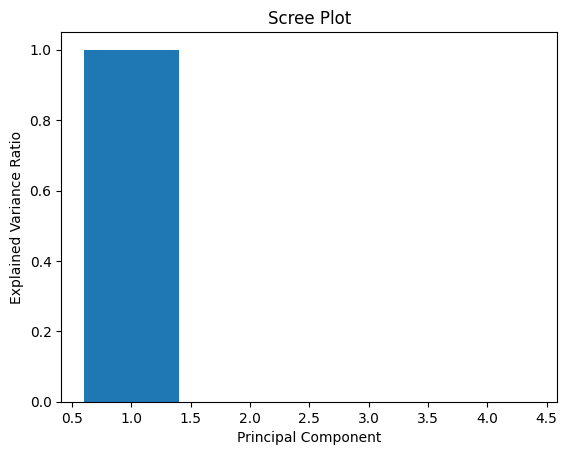

In [42]:
# See how much variance each component explains
explained_variance = pca.explained_variance_ratio_
print("Variance explained by each component:", explained_variance)
print("Total variance explained:", sum(explained_variance))

# Optional: Plot the explained variance
import matplotlib.pyplot as plt

plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

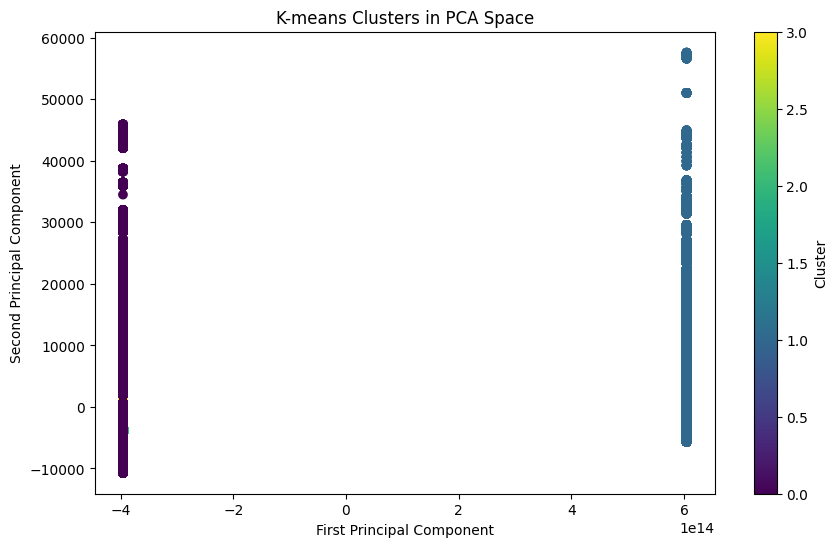


Cluster sizes:
Cluster
0    2328938
1    1576179
3      77274
2        720
Name: count, dtype: int64


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

# 1. Create DataFrame with PCA transformed data
pca_df = pd.DataFrame(transformed_data, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# 2. Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(transformed_data)

# 3. Add cluster labels to PCA dataframe
pca_df['Cluster'] = cluster_labels


# 5. Get cluster centers
cluster_centers = kmeans.cluster_centers_

# 6. Basic analysis of clusters
print("\nCluster sizes:")
print(pca_df['Cluster'].value_counts())

# 7. Calculate silhouette score
silhouette_avg = silhouette_score(transformed_data, cluster_labels)
print(f"\nSilhouette Score: {silhouette_avg}")